In [1]:
from __future__ import print_function
# from global_config import USE_STEREOCHEMISTRY
import argparse
from numpy.random import shuffle # for random selection
import rdkit.Chem as Chem          # molecule building
from rdkit.Chem import AllChem
from collections import defaultdict
import rdkit.Chem.Draw as Draw
from rdkit import RDLogger
import datetime # for info files
import json # for dumping
import sys  # for commanad line
import os   # for file paths
import re 
import itertools
import bson
import pandas as pd
import matplotlib.pyplot as plt
import json
from rdkit import DataStructs
%matplotlib inline
# from makeit.retro.draw import *

## Helper Functions

In [2]:
USE_STEREOCHEMISTRY = True

def mols_from_smiles_list(all_smiles):
    '''Given a list of smiles strings, this function creates rdkit
    molecules'''
    mols = []
    for smiles in all_smiles:
        if not smiles: continue
        mols.append(Chem.MolFromSmiles(smiles))
    return mols

def mol_list_to_inchi(mols):
    '''List of RDKit molecules to InChI string separated by ++'''
    inchis = [Chem.MolToInchi(mol) for mol in mols]
    return ' ++ '.join(sorted(inchis))

def mol_list_from_inchi(inchis):
    '''InChI string separated by ++ to list of RDKit molecules'''
    return [Chem.MolFromInchi(inchi.strip()) for inchi in inchis.split('++')]

def get_changed_atoms(reactants, products):
    '''Looks at mapped atoms in a reaction and determines which ones changed'''
    err = 0
    prod_atoms, prod_atom_tags = get_tagged_atoms_from_mols(products)

    if v: print('Products contain {} tagged atoms'.format(len(prod_atoms)))
    if v: print('Products contain {} unique atom numbers'.format(len(set(prod_atom_tags))))

    reac_atoms, reac_atom_tags = get_tagged_atoms_from_mols(reactants)
    if len(set(prod_atom_tags)) != len(set(reac_atom_tags)):
        if v: print('warning: different atom tags appear in reactants and products')
        err = 1
    if len(prod_atoms) != len(reac_atoms):
        if v: print('warning: total number of tagged atoms differ, stoichometry != 1?')
        #err = 1

    # Find differences 
    changed_atoms = []
    changed_atom_tags = []
    #print(reac_atom_tags)
    #print(prod_atom_tags)

    # Product atoms that are different from reactant atom equivalent
    for i, prod_tag in enumerate(prod_atom_tags):

        for j, reac_tag in enumerate(reac_atom_tags):
            if reac_tag != prod_tag: continue
            if reac_tag not in changed_atom_tags: # don't bother comparing if we know this atom changes
                # If atom changed, add
                if atoms_are_different(prod_atoms[i], reac_atoms[j]):
                    changed_atoms.append(reac_atoms[j])
                    changed_atom_tags.append(reac_tag)
                    break
                # If reac_tag appears multiple times, add (need for stoichometry > 1)
                if prod_atom_tags.count(reac_tag) > 1:
                    changed_atoms.append(reac_atoms[j])
                    changed_atom_tags.append(reac_tag)
                    break

    # Reactant atoms that do not appear in product (tagged leaving groups)
    for j, reac_tag in enumerate(reac_atom_tags):
        if reac_tag not in changed_atom_tags:
            if reac_tag not in prod_atom_tags:
                changed_atoms.append(reac_atoms[j])
                changed_atom_tags.append(reac_tag)

    # 	if v: 
    print('{} tagged atoms in reactants change 1-atom properties'.format(len(changed_atom_tags)))
    for smarts in [atom.GetSmarts() for atom in changed_atoms]:
        print('  {}'.format(smarts))

    return changed_atoms, changed_atom_tags, err

def get_tagged_atoms_from_mols(mols):
    '''Takes a list of RDKit molecules and returns total list of
    atoms and their tags'''
    atoms = []
    atom_tags = []
    for mol in mols:
        new_atoms, new_atom_tags = get_tagged_atoms_from_mol(mol)
        atoms += new_atoms 
        atom_tags += new_atom_tags
    return atoms, atom_tags

def get_tagged_atoms_from_mol(mol):
    '''Takes an RDKit molecule and returns list of tagged atoms and their
    corresponding numbers'''
    atoms = []
    atom_tags = []
    for atom in mol.GetAtoms():
        if ':' in atom.GetSmarts():
            atoms.append(atom)
            atom_tags.append(atom.GetSmarts().split(':')[1][:-1])
    return atoms, atom_tags

def atoms_are_different(atom1, atom2, level = 1):
    '''Compares two RDKit atoms based on basic properties'''

    if atom1.GetSmarts() != atom2.GetSmarts(): return True # should be very general
    if atom1.GetAtomicNum() != atom2.GetAtomicNum(): return True # must be true for atom mapping
    if atom1.GetTotalNumHs() != atom2.GetTotalNumHs(): return True
    if atom1.GetFormalCharge() != atom2.GetFormalCharge(): return True
    if atom1.GetDegree() != atom2.GetDegree(): return True
    #if atom1.IsInRing() != atom2.IsInRing(): return True
    if atom1.GetNumRadicalElectrons() != atom2.GetNumRadicalElectrons(): return True
    # TODO: add # pi electrons like ICSynth?

    # Check bonds and nearest neighbor identity
    if level >= 1:
        bonds1 = sorted([bond_to_label(bond) for bond in atom1.GetBonds()]) 
        bonds2 = sorted([bond_to_label(bond) for bond in atom2.GetBonds()]) 
        if bonds1 != bonds2: return True

        # # Check neighbors too (already taken care of with previous lines)
        # neighbors1 = sorted([atom.GetAtomicNum() for atom in atom1.GetNeighbors()])
        # neighbors2 = sorted([atom.GetAtomicNum() for atom in atom2.GetNeighbors()])
        # if neighbors1 != neighbors2: return True

    return False

def bond_to_label(bond):
    '''This function takes an RDKit bond and creates a label describing
    the most important attributes'''
    # atoms = sorted([atom_to_label(bond.GetBeginAtom().GetIdx()), \
    # 			    atom_to_label(bond.GetEndAtom().GetIdx())])
    a1_label = str(bond.GetBeginAtom().GetAtomicNum())
    a2_label = str(bond.GetEndAtom().GetAtomicNum())
    if bond.GetBeginAtom().HasProp('molAtomMapNumber'):
        a1_label += bond.GetBeginAtom().GetProp('molAtomMapNumber')
    if bond.GetEndAtom().HasProp('molAtomMapNumber'):
        a2_label += bond.GetEndAtom().GetProp('molAtomMapNumber')
    atoms = sorted([a1_label, a2_label])

    return '{}{}{}'.format(atoms[0], bond.GetSmarts(), atoms[1])

def get_fragments_for_changed_atoms(mols, changed_atom_tags, radius = 0, 
    category = 'reactants', expansion = []):
    '''Given a list of RDKit mols and a list of changed atom tags, this function
    computes the SMILES string of molecular fragments using MolFragmentToSmiles 
    for all changed fragments'''

    fragments = ''
    for mol in mols:
        # Initialize list of replacement symbols (updated during expansion)
        symbol_replacements = []

        # Are we looking for groups? (reactants only)
        if category == 'reactants':
            groups = get_special_groups(mol)
        else:
            groups = []

        # Build list of atoms to use
        atoms_to_use = []
        for atom in mol.GetAtoms():
            # Check self (only tagged atoms)
            if ':' in atom.GetSmarts():
                if atom.GetSmarts().split(':')[1][:-1] in changed_atom_tags:
                    atoms_to_use.append(atom.GetIdx())
                    symbol = atom.GetSmarts()
                    # CUSTOM SYMBOL CHANGES
                    if atom.GetTotalNumHs() == 0:
                        # Be explicit when there are no hydrogens
                        if ':' in symbol: # stick H0 before label
                            symbol = symbol.replace(':', ';H0:')
                        else: # stick before end
                            symbol = symbol.replace(']', ';H0]')

                        # print('Being explicit about H0!!!!')
                    if atom.GetFormalCharge() == 0:
                        # Also be explicit when there is no charge
                        if ':' in symbol: 
                            symbol = symbol.replace(':', ';+0:')
                        else:
                            symbol = symbol.replace(']', ';+0]')
                    if USE_STEREOCHEMISTRY:
                        if atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
                            # Be explicit when there is a tetrahedral chiral tag
                            if atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
                                tag = '@'
                            elif atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
                                tag = '@@'
                            if ':' in symbol:
                                symbol = symbol.replace(':', ';{}:'.format(tag))
                            else:
                                symbol = symbol.replace(']', ';{}]'.format(tag))
                    if symbol != atom.GetSmarts():
                        symbol_replacements.append((atom.GetIdx(), symbol))
                    continue

        # Check neighbors (any atom)
        for k in range(radius):
            atoms_to_use, symbol_replacements = expand_atoms_to_use(mol, atoms_to_use, 
                groups = groups, symbol_replacements = symbol_replacements)

        if category == 'products':
            # Add extra labels to include (for products only)
            if expansion:
                for atom in mol.GetAtoms():
                    if ':' not in atom.GetSmarts(): continue
                    label = atom.GetSmarts().split(':')[1][:-1]
                    if label in expansion and label not in changed_atom_tags:
                        atoms_to_use.append(atom.GetIdx())
                        # Make the expansion a wildcard
                        symbol_replacements.append((atom.GetIdx(), convert_atom_to_wildcard(atom)))	
                        if v: print('expanded label {} to wildcard in products'.format(label))

            # Make sure unmapped atoms are included (from products)
            for atom in mol.GetAtoms():
                if not atom.HasProp('molAtomMapNumber'): 
                    atoms_to_use.append(atom.GetIdx())

        # Define new symbols to replace terminal species with wildcards
        # (don't want to restrict templates too strictly)
        symbols = [atom.GetSmarts() for atom in mol.GetAtoms()]
        for (i, symbol) in symbol_replacements:
            symbols[i] = symbol

        if not atoms_to_use: continue
        # if v:
        # 	print('~~ replacement for this ' + category[:-1])
        # 	print('{} -> {}'.format([mol.GetAtomWithIdx(x).GetSmarts() for (x, s) in symbol_replacements], 
        # 		                    [s for (x, s) in symbol_replacements]))
        # Remove molAtomMapNumber before canonicalization
        [x.ClearProp('molAtomMapNumber') for x in mol.GetAtoms()]
        fragments += '(' + AllChem.MolFragmentToSmiles(mol, atoms_to_use, 
            atomSymbols = symbols, allHsExplicit = True, 
            isomericSmiles = USE_STEREOCHEMISTRY, allBondsExplicit = True) + ').'
    return fragments[:-1]

def get_special_groups(mol):
    '''Given an RDKit molecule, this function returns a list of tuples, where
    each tuple contains the AtomIdx's for a special group of atoms which should 
    be included in a fragment all together. This should only be done for the 
    reactants, otherwise the products might end up with mapping mismatches'''

    if SUPER_GENERAL_TEMPLATES: return []

    # Define templates, based on Functional_Group_Hierarchy.txt from Greg Laandrum
    group_templates = [ 
        'C(=O)Cl', # acid chloride
        'C(=O)[O;H,-]', # carboxylic acid
        '[$(S-!@[#6])](=O)(=O)(Cl)', # sulfonyl chloride
        '[$(B-!@[#6])](O)(O)', # boronic acid
        '[$(N-!@[#6])](=!@C=!@O)', # isocyanate
        '[N;H0;$(N-[#6]);D2]=[N;D2]=[N;D1]', # azide
        'O=C1N(Br)C(=O)CC1', # NBS brominating agent
        'C=O', # carbonyl
        'ClS(Cl)=O', # thionyl chloride
        '[Mg][Br,Cl]', # grinard (non-disassociated)
        '[#6]S(=O)(=O)[O]', # RSO3 leaving group
        '[O]S(=O)(=O)[O]', # SO4 group
        '[N-]=[N+]=[C]', # diazo-alkyl
        ]

    # Build list
    groups = []
    for template in group_templates:
        matches = mol.GetSubstructMatches(Chem.MolFromSmarts(template))
        groups.extend(list(matches))
    return groups

def expand_atoms_to_use(mol, atoms_to_use, groups = [], symbol_replacements = []):
    '''Given an RDKit molecule and a list of AtomIdX which should be included
    in the reaction, this function expands the list of AtomIdXs to include one 
    nearest neighbor with special consideration of (a) unimportant neighbors and
    (b) important functional groupings'''

    # Copy
    new_atoms_to_use = atoms_to_use[:]

    # Look for all atoms in the current list of atoms to use
    for atom in mol.GetAtoms():
        if atom.GetIdx() not in atoms_to_use: continue
        # Look for all nearest neighbors of the currently-included atoms
        for neighbor in atom.GetNeighbors():
            # Evaluate nearest neighbor atom to determine what should be included
            new_atoms_to_use, symbol_replacements = \
                    expand_atoms_to_use_atom(mol, new_atoms_to_use, neighbor.GetIdx(), 
                        groups = groups, symbol_replacements = symbol_replacements)

    return new_atoms_to_use, symbol_replacements

def expand_atoms_to_use_atom(mol, atoms_to_use, atom_idx, groups = [], symbol_replacements = []):
    '''Given an RDKit molecule and a list of AtomIdx which should be included
    in the reaction, this function extends the list of atoms_to_use by considering 
    a candidate atom extension, atom_idx'''

    # Skip current candidate atom if it is already included
    if atom_idx in atoms_to_use:
        return atoms_to_use, symbol_replacements

    # See if this atom belongs to any groups
    found_in_group = False
    for group in groups:
        if int(atom_idx) in group: # int correction
            if v: print('added group centered at {}'.format(atom_idx))
            # Add the whole list, redundancies don't matter
            atoms_to_use.extend(list(group)) 
            found_in_group = True
    if found_in_group:	return atoms_to_use, symbol_replacements

    # How do we add an atom that wasn't in an identified important functional group?
    # Develop special SMARTS symbol

    # Include this atom
    atoms_to_use.append(atom_idx)

    # Look for replacements
    symbol_replacements.append((atom_idx, convert_atom_to_wildcard(mol.GetAtomWithIdx(atom_idx))))

    return atoms_to_use, symbol_replacements

def convert_atom_to_wildcard(atom):
    '''This function takes an RDKit atom and turns it into a wildcard 
    using hard-coded generalization rules. This function should be used
    when candidate atoms are used to extend the reaction core for higher
    generalizability'''

    if SUPER_GENERAL_TEMPLATES:
        if ':' in atom.GetSmarts():
            # Fully generalize atom-mappped neighbors because they are aren't a leaving group
            label = re.search('\:[0-9]+\]', atom.GetSmarts())
            return '[*{}'.format(label.group())

    if not SUPER_GENERAL_TEMPLATES:

        # Is this a terminal atom? We can tell if the degree is one
        if atom.GetDegree() == 1:
            return atom.GetSmarts()

    # Initialize
    symbol = '['

    # Add atom primitive (don't use COMPLETE wildcards)
    if atom.GetAtomicNum() != 6:
        symbol += '#{};'.format(atom.GetAtomicNum())
    elif atom.GetIsAromatic():
        symbol += 'c;'
    else:
        symbol += 'C;'

    if not SUPER_GENERAL_TEMPLATES:
        # Charge is important
        if atom.GetFormalCharge() != 0:
            charges = re.search('([-+]+[1-9]?)', atom.GetSmarts())
            if charges: symbol += charges.group() + ';'

    # Strip extra semicolon
    if symbol[-1] == ';': symbol = symbol[:-1]

    # Close with label or with bracket
    label = re.search('\:[0-9]+\]', atom.GetSmarts())
    if label: 
        symbol += label.group()
    else:
        symbol += ']'

    if v: 
        if symbol != atom.GetSmarts():
            print('Improved generality of atom SMARTS {} -> {}'.format(atom.GetSmarts(), symbol))

    return symbol

def expand_changed_atom_tags(changed_atom_tags, reactant_fragments):
    '''Given a list of changed atom tags (numbers as strings) and a string consisting
    of the reactant_fragments to include in the reaction transform, this function 
    adds any tagged atoms found in the reactant side of the template to the 
    changed_atom_tags list so that those tagged atoms are included in the products'''

    expansion = []
    atom_tags_in_reactant_fragments = re.findall('\:([[0-9]+)\]', reactant_fragments)
    for atom_tag in atom_tags_in_reactant_fragments:
        if atom_tag not in changed_atom_tags:
            expansion.append(atom_tag)
    if v: print('after building reactant fragments, additional labels included: {}'.format(expansion))
    return expansion

In [66]:
v =True
N = 15
SUPER_GENERAL_TEMPLATES = True
data = bson.decode_file_iter(open('dump/reaction_examples/lowe_1976-2013_USPTOgrants.bson', 'rb'))
print(type(data))
i = -1
# N = min([15, len(data)])
total_attempted = 0 # total reactions simulated (excludes skipped)
total_correct = 0 # actual products predicted
total_precise = 0 # ONLY actual products predicted
total_unmapped = 0
total_partialmapped = 0
total_nonreaction = 0

for c, example_doc in enumerate(data):
    i += 1

        # Are we done?
    if i == N:
        i -= 1
        break

    #     if v: 
    print('##################################')
    print('###        RXN {}'.format(i))
    print('##################################')

    # STEP 1
    
    try:
        # Unpack
        reaction_smiles = str(example_doc["reaction_smiles"])
        reactants, agents, products = [mols_from_smiles_list(x) for x in 
                                    [mols.split('.') for mols in reaction_smiles.split('>')]]
        [Chem.SanitizeMol(mol) for mol in reactants + agents + products]
    except Exception as e:
        # can't sanitize -> skip
        print(e)
        print('Could not load SMILES or sanitize')
        print('ID: {}'.format(example_doc['_id']))
        continue

    try:
        # Check product atom mapping
        skip = False
        for product in products:
            if sum([a.HasProp('molAtomMapNumber') for a in product.GetAtoms()]) < len(product.GetAtoms()):
                print('Not all product atoms have atom mapping, skipping')
                print('ID: {}'.format(example_doc['_id']))
                print('REACTION: {}'.format(example_doc['reaction_smiles']))
                skip = True
        if skip: 
            total_partialmapped += 1
            continue
            
    # STEP 1 Ends
    # STEP 2
        # Get unique InChi for products we are looking for
        # remove cases where product shows up
        product_inchis_split = mol_list_to_inchi(products).split(' ++ ')
        for reactant in reactants:
            reactant_inchi = mol_list_to_inchi([reactant])
            if reactant_inchi in product_inchis_split:
                product_inchis_split.remove(reactant_inchi)
        product_inchis = ' ++ '.join(product_inchis_split)

#         if v: print(reaction_smiles)
        print("Reaction SMILES: ",reaction_smiles)
        if None in reactants + products:
            print('Could not parse all molecules in reaction, skipping')
            print('ID: {}'.format(example_doc['_id']))
            continue
        if not product_inchis: 
            print('Product molecules no different than reactant molecules')
            print('ID: {}'.format(example_doc['_id']))
            total_nonreaction += 1
            continue

        # Calculate changed atoms
        changed_atoms, changed_atom_tags, err = get_changed_atoms(reactants, products)
        if err: 
            print('Could not get changed atoms')
            print('ID: {}'.format(example_doc['_id']))
            continue
        if not changed_atom_tags:
            print('No atoms changed?')
            print('ID: {}'.format(example_doc['_id']))
            continue
        # Step 2 ends
        
        # Step 3
        # Get fragments for reactants
        reactant_fragments = get_fragments_for_changed_atoms(reactants, changed_atom_tags, 
            radius = 1, expansion = [], category = 'reactants')
        # Get fragments for products 
        # (WITHOUT matching groups but WITH the addition of reactant fragments)
        product_fragments  = get_fragments_for_changed_atoms(products, changed_atom_tags, 
            radius = 0, expansion = expand_changed_atom_tags(changed_atom_tags, reactant_fragments),
            category = 'products')

        # Report transform
        rxn_string = '{}>>{}'.format(reactant_fragments, product_fragments)
#         if v: print('\nOverall fragment transform: {}'.format(rxn_string))
        print('\nOverall fragment transform: {}'.format(rxn_string))
        # Load into RDKit
        rxn = AllChem.ReactionFromSmarts(rxn_string)
        if rxn.Validate()[1] != 0: 
            print('Could not validate reaction successfully')
            print('ID: {}'.format(example_doc['_id']))
            print('rxn_string: '.format(rxn_string))
            continue
    #     except:
    #         print("Nooo")
    #         continue
    #             [Chem.SanitizeMol(mol) for mol in reactants + agents + products]
    except Exception as e:
#                 if v: 
                print(e)
                print('skipping')
                    #raw_input('Enter anything to continue')
                continue
    break

<class 'generator'>
##################################
###        RXN 0
##################################
Reaction SMILES:  C(=O)([O-])[O-].[Cu+2:5].O=C=O.[OH:9][CH2:10][CH2:11][N:12]([CH2:16][CH2:17][OH:18])[CH2:13][CH2:14][OH:15].[Cu]>CC(=O)O.O>[N:12]([CH2:16][CH2:17][OH:18])([CH2:13][CH2:14][OH:15])[CH2:11][CH2:10][OH:9].[Cu:5]
Product molecules no different than reactant molecules
ID: 571fa8f71d41c81a5e6d8330
##################################
###        RXN 1
##################################
Reaction SMILES:  CO[c:3]1[cH:4][c:5]([C:9]2([CH2:12][C:13]([Cl:16])([Cl:15])[Cl:14])[CH2:11][O:10]2)[cH:6][cH:7][cH:8]1.Clc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1.Fc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1.Clc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1Cl.C(Oc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1)C.C(Oc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1)c1ccccc1.Clc1ccc(C2(CC(Cl)(Cl)Cl)CO2)cc1.[Br:117]c1ccc(C2(CC(Cl)(Cl)Cl)CO2)cc1>>[Br:117][c:3]1[cH:4][c:5]([C:9]2([CH2:12][C:13]([Cl:16])([Cl:15])[Cl:14])[CH2:11][O:10]2)[cH:6][cH:7][cH:8]1
Products contain 15 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:372: FutureWarning: Possible nested set at position 4


# Playing around with the dump files

In [2]:
data = bson.decode_file_iter(open('dump/askcos_transforms/lowe_refs_general_v3.bson', 'rb'))
smarts = [smart for smart in data]
print(smarts[:10])
# smarts = [example_doc["reaction_smiles"] for example_doc in data]
# print(smiles[-100:])

[{'_id': ObjectId('575748041d41c8f86e9068f8'), 'count': 11, 'rxn_example': 'CO[c:3]1[cH:4][c:5]([C:9]2([CH2:12][C:13]([Cl:16])([Cl:15])[Cl:14])[CH2:11][O:10]2)[cH:6][cH:7][cH:8]1.Clc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1.Fc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1.Clc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1Cl.C(Oc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1)C.C(Oc1cc(C2(CC(Cl)(Cl)Cl)CO2)ccc1)c1ccccc1.Clc1ccc(C2(CC(Cl)(Cl)Cl)CO2)cc1.[Br:117]c1ccc(C2(CC(Cl)(Cl)Cl)CO2)cc1>>[Br:117][c:3]1[cH:4][c:5]([C:9]2([CH2:12][C:13]([Cl:16])([Cl:15])[Cl:14])[CH2:11][O:10]2)[cH:6][cH:7][cH:8]1', 'name': '', 'references': [ObjectId('571fa8f71d41c81a5e6d8331'), ObjectId('571fa8f81d41c81a5e6d8cd6'), ObjectId('571fa8f81d41c81a5e6d8cd7'), ObjectId('571fa8fa1d41c81a5e6dd420'), ObjectId('571fa8fa1d41c81a5e6dd421'), ObjectId('571fa8fd1d41c81a5e6e3c87'), ObjectId('571fa8fd1d41c81a5e6e3c88'), ObjectId('571fa9001d41c81a5e6ea03e'), ObjectId('571fa9001d41c81a5e6ea03f'), ObjectId('571fa9571d41c81a5e792d60'), ObjectId('571fa97d1d41c81a5e7dfc21')], 'reaction_smarts': 

In [3]:
sorted_smarts  = sorted(smarts, key = lambda x: x['count'],reverse = True)
print(sorted_smarts[0]['reaction_smarts'],sorted_smarts[0]['count'],sorted_smarts[1]['rxn_example'])

[*:1]-[OH;+0:2]>>[*:1]-[O;H0;+0:2]-[C] 41076 [OH:1][c:2]1[cH:14][cH:13][c:12]([N+:15]([O-])=O)[cH:11][c:3]1[C:4]([CH2:6][CH2:7][C:8]([OH:10])=[O:9])=[O:5].O.O.O.O.O.O.O.S(O)(O)(=O)=O>[NH4+].[OH-].O>[NH2:15][c:12]1[cH:13][cH:14][c:2]([OH:1])[c:3]([cH:11]1)[C:4]([CH2:6][CH2:7][C:8]([OH:10])=[O:9])=[O:5]


# Visualising SMILES Strings

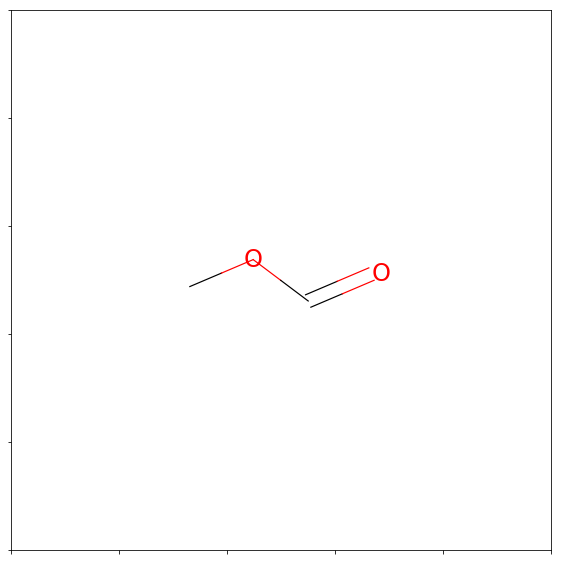

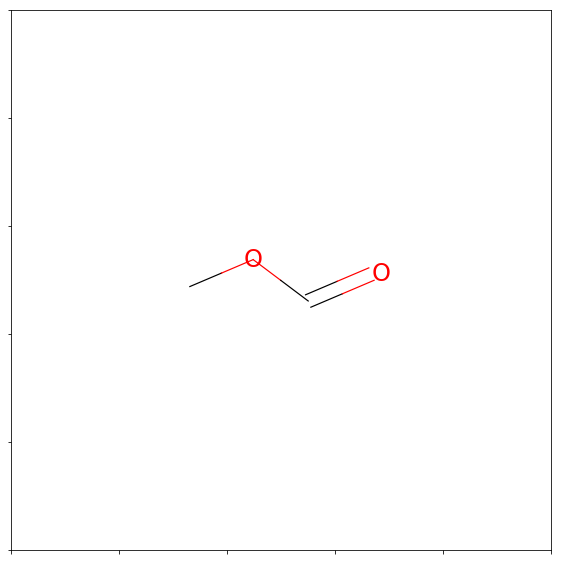

In [69]:
temp = Chem.MolFromSmiles('COC=O')
Draw.MolToMPL(temp)
# def plot_mol(reactant,product):
#     # temp_smile = sorted_smarts[0]['rxn_example']
#     temp_mol_reactant = Chem.MolFromSmiles(reactant)
#     print("Reactant: ")
#     Draw.MolToMPL(temp_mol_reactant)
#     print("Product: ")
#     temp_mol_product = Chem.MolFromSmiles(product)
#     Draw.MolToMPL(temp_mol_product)
    
# for i in range(10):
#     print(sorted_smarts[i]['reaction_smarts'])
#     print("Reaction Number: ",i+1)
#     plot_mol(sorted_smarts[i]['rxn_example'].split('>')[0],sorted_smarts[i]['rxn_example'].split('>')[-1])
#     print('-------------------------------------------------------------------------------------------------')
# plot_mol('[OH:1][c:2]1[cH:14][cH:13][c:12]([N+:15]([O-])=O)[cH:11][c:3]1[C:4]([CH2:6][CH2:7][C:8]([OH:10])=[O:9])=[O:5].O.O.O.O.O.O.O.S(O)(O)(=O)=O','[NH2:15][c:12]1[cH:13][cH:14][c:2]([OH:1])[c:3]([cH:11]1)[C:4]([CH2:6][CH2:7][C:8]([OH:10])=[O:9])=[O:5]')

# Create Graph of Rank vs Popularity

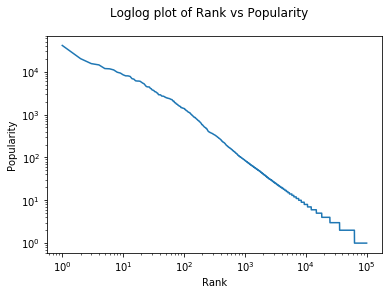

In [5]:
from matplotlib import pyplot as plt    

popularity,ranks = [],[]
for i in range(100000):
    ranks.append(i+1)
    popularity.append(sorted_smarts[i]['count'])
    
fig = plt.figure()
fig.suptitle('Loglog plot of Rank vs Popularity')
plt.loglog(ranks,popularity)
plt.xlabel("Rank")
plt.ylabel("Popularity")
plt.show()


# Using MongoClient (running MongoDB server locally)

In [2]:
from pymongo import MongoClient
from bson.objectid import ObjectId
client = MongoClient()
db = client.reaction_examples
print(db.collection_names())
collection = db['lowe_1976-2013_USPTOgrants']

data = bson.decode_file_iter(open('dump/askcos_transforms/lowe_refs_general_v3.bson', 'rb'))
smarts = [smart for smart in data]
sorted_smarts  = sorted(smarts, key = lambda x: x['count'],reverse = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  """


['lowe_1976-2013_USPTOgrants', 'lowe_1976-2013_USPTOgrants_reactions']


In [28]:
for i in range(5):
    print("SMART TEMPLATE: ")
    print(sorted_smarts[i]['reaction_smarts'])
    for j in range(5):
        print(collection.find_one({"_id": sorted_smarts[i]['references'][j]}))
# print(sorted_smarts[0]['reaction_smarts'], sorted_smarts[0]['reactants'][j]) 
# print(collection.find_one({"_id": ObjectId('571fa8fa1d41c81a5e6dd420')}))

SMART TEMPLATE: 
[*:1]-[OH;+0:2]>>[*:1]-[O;H0;+0:2]-[C]
{'_id': ObjectId('571fa8f71d41c81a5e6d838d'), 'reaction_smiles': 'C([O:4][c:5]1[cH:6][c:7]([cH:16][cH:17][c:18]1[N+:19]([O-:21])=[O:20])[C:8]([CH:10]([CH3:15])[CH2:11][C:12]([OH:14])=[O:13])=[O:9])(=O)C.Cl>[OH-].[Na+]>[OH:4][c:5]1[cH:6][c:7]([cH:16][cH:17][c:18]1[N+:19]([O-:21])=[O:20])[C:8]([CH:10]([CH3:15])[CH2:11][C:12]([OH:14])=[O:13])=[O:9]', 'reference': '03931177', 'random': 0.6675286252069141}
{'_id': ObjectId('571fa8f71d41c81a5e6d8393'), 'reaction_smiles': 'C([O:8][c:9]1[cH:10][c:11]([cH:19][cH:20][c:21]1[C:22]#[N:23])[C:12]([CH2:14][CH2:15][C:16]([OH:18])=[O:17])=[O:13])c1ccccc1.Br>CC(=O)O>[C:22]([c:21]1[cH:20][cH:19][c:11]([C:12]([CH2:14][CH2:15][C:16]([OH:18])=[O:17])=[O:13])[cH:10][c:9]1[OH:8])#[N:23]', 'reference': '03931177', 'random': 0.5370079220258376}
{'_id': ObjectId('571fa8f71d41c81a5e6d840a'), 'reaction_smiles': '[n:1]1[cH:6][cH:5][cH:4][c:3]2[CH2:7][c:8]3[cH:14][c:13]([C:15]([O:17]C(C)C)=[O:16])[cH:12][cH:11

# Running reaction template on molecule

In [3]:
smiles = 'COC'
reaction_smarts = '[*:1]-[OH;+0:2]>>[*:1]-[O;H0;+0:2]-[C]'
mol = Chem.MolFromSmiles(smiles)
reaction_smarts_synth = '(' + reaction_smarts.split('>')[2] + ')>>(' + reaction_smarts.split('>')[0] + ')'
print("Modified SMARTS template: ",reaction_smarts_synth)
rxn = AllChem.ReactionFromSmarts(reaction_smarts_synth)
outcomes = rxn.RunReactants([mol])
print("Before sanitizing, number of outcomes: ",len(outcomes))
for x in outcomes:
    Chem.SanitizeMol(x[0])
    print(Chem.MolToSmiles(x[0]))

Modified SMARTS template:  ([*:1]-[O;H0;+0:2]-[C])>>([*:1]-[OH;+0:2])
Before sanitizing, number of outcomes:  2
CO
CO


In [35]:
print("Number of smart templates: ",len(sorted_smarts))

Number of smart templates:  140284


# Running all reaction templates on given molecule (BFS)

In [19]:
def run_all_templates(mol_string, steps, sorted_smarts):
    
    current_step,step_wise_mp,step_wise_products,step_wise_reac_prod, step_wise_template_numbers = 0,[],[],[],[]
    mols = [mol_string]
    
    while current_step < steps:
        
        local_mp,local_products,local_reac_prod, local_template_numbers = [],[],{},[]
        
        for mol_string in mols:
            
            mol = Chem.MolFromSmiles(mol_string)
            mp = {}
            
            for i,smarts_dict in enumerate(sorted_smarts):
                
                local_ans = set()
                reaction_smarts = smarts_dict['reaction_smarts']
                
                # Reversing smart template
                reaction_smarts_synth = '(' + reaction_smarts.split('>')[2] + ')>>(' + reaction_smarts.split('>')[0] + ')'
                
                # Applying reaction template
                rxn = AllChem.ReactionFromSmarts(reaction_smarts_synth)
                outcomes = rxn.RunReactants([mol])            
                
                for x in outcomes:
                    Chem.SanitizeMol(x[0])
                    local_ans.add(Chem.MolToSmiles(x[0]))
                if len(local_ans) > 0:
                    mp[(reaction_smarts_synth,i)] = list(local_ans)
                    local_template_numbers.append(i)
                    
            local_mp.append(mp)
            local_products.extend([item for sublist in list(mp.values()) for item in sublist])
            local_reac_prod[mol_string] = [item for sublist in list(mp.values()) for item in sublist]
            
        local_template_numbers = sorted(local_template_numbers)
            
        step_wise_mp.append(local_mp)
        step_wise_products.append(local_products)
        step_wise_reac_prod.append(local_reac_prod)
        step_wise_template_numbers.append(local_template_numbers)
        
        current_step += 1
        
        print("Step: ", current_step)
        print('\n')
        print("Products: ", local_products)
        print('\n')
        print("Number of unique products: ",len(list(set(local_products))))
        print('\n')
        print("Reactant - Product mapping: ")
        print(json.dumps(local_reac_prod, indent=4, sort_keys=True))
        print('\n')
        print("Reaction Template numbers used: ", local_template_numbers)
        print('\n' * 3)
        
        mols = list(set(local_products))
        
    return step_wise_mp, step_wise_products, step_wise_reac_prod, step_wise_template_numbers

mp,products,reac_prod,template_numbers = run_all_templates('CCCC(=O)OC',5, sorted_smarts[:1700])

print("Final step-wise dictionary: ", mp)
print('\n' * 3)
print("Final step-wise products: ", products)
print('\n' * 3)
print("Final reac-prod dictionary: ", json.dumps(reac_prod, indent=4, sort_keys=True))
print('\n' * 3)
print("Numbers of all templates used: ", template_numbers)

Step:  1


Products:  ['CCCCO', 'CCCC(O)O', 'CCCCO', 'CCCC(=O)[O-]', 'CCC(=O)O', 'CCC', 'CC(=O)O', 'CC', 'CCCC', 'CCCC=O', 'COC(C)=O', 'O=C1CCC1', 'CCCC=O', 'O=C1CCC1', 'OC1(O)CCC1', 'CC=CC(=O)O', 'OC1(O)CCC1', 'C=C(C)O', 'O=C1CCC1', 'COC(C)=O', 'CCCC(=O)[O-]', 'CCCC(=O)O.O', 'O=C1CCO1', 'CCOC=O', 'CCCO', 'CC(C)=O', 'CO', 'CCC=O', 'O=C1CCO1', 'CCOC=O', 'CCCC(=O)O', 'CC(C)(O)O', 'O=CO', 'CCCO']


Number of unique products:  24


Reactant - Product mapping: 
{
    "CCCC(=O)O": [
        "CCCCO",
        "CCCC(O)O",
        "CCCCO",
        "CCCC(=O)[O-]",
        "CCC(=O)O",
        "CCC",
        "CC(=O)O",
        "CC",
        "CCCC",
        "CCCC=O",
        "COC(C)=O",
        "O=C1CCC1",
        "CCCC=O",
        "O=C1CCC1",
        "OC1(O)CCC1",
        "CC=CC(=O)O",
        "OC1(O)CCC1",
        "C=C(C)O",
        "O=C1CCC1",
        "COC(C)=O",
        "CCCC(=O)[O-]",
        "CCCC(=O)O.O",
        "O=C1CCO1",
        "CCOC=O",
        "CCCO",
        "CC(C)=O",
        "CO",
 

Step:  3


Products:  ['CCCC(=O)O', 'CCCCO', 'OCO', 'CCCC([O-])O', 'CCC', 'CC', 'CC(O)O', 'CCC(O)O', 'COC(C)O', 'CCC=CO', 'CCC=CO', 'CC=CC(O)O', 'O=CO', 'CC(C)(O)O', 'OC1CCO1', 'CCOCO', 'OC1CCO1', 'CCOCO', 'C1=CCC1', 'CCC=C(O)O', 'CCCO', 'CCC=C(O)O', 'CCC', 'O=CCO', '[O-]CCO', 'CO', 'CCO', 'OC=CO', 'C=CO', 'OCO', 'O=C[O-]', 'CO', 'O.O=CO', 'O=C(O)O', 'CCC', 'C1=CCC1', 'C=CCO', 'CCC=O', 'C=CC', 'C=CC=O.O', 'CC(=O)O', 'C=CO', 'CC(=O)O', 'C=CCO', 'OC1C=CO1', 'C1=COC1', 'CCO', 'O=C1CCO1', 'O=C1CCO1', 'CC(=O)[O-]', 'C=C[O-]', 'C=CC', 'C=CC=O', 'C=CC=O', 'CC=O', 'C=C(O)O', 'O.O=C1C=CO1', 'CC(=O)[O-]', 'COC', 'COC=O', 'O.O=C1C=CO1', 'CO', 'C[O-]', 'COC.O', 'CC=CCO', 'CC=CC(O)O', 'CC=CCO', 'CCCC(=O)O', 'CCCC(=O)O', 'CC=CC(=O)[O-]', 'CC=CC', 'CC=CC=O', 'COC(C)=O', 'O=C1C=CC1', 'CC=CC=O', 'O=C1C=CC1', 'OC1(O)C=CC1', 'OC1(O)C=CC1', 'C=C(C)O', 'O=C1C=CC1', 'COC(C)=O', 'CC=CC(=O)[O-]', 'C=C(C)O', 'CC=CC(=O)O.O', 'C=CCO', 'CO', 'CC=O', 'C=CC=O', 'CC=CC(=O)O', 'CC(C)(O)O', 'O=CO', 'C=CCO', 'CC(O)=CC(

Step:  4


Products:  ['[O-]CCO', 'C[O-]', 'O=CCO', 'CC[O-]', 'CC=O', 'O.O=CC[O-]', 'CC=CC(=O)[O-]', 'CCCC([O-])O', 'CCCC([O-])O', 'CC=CCO', 'CC=CC[O-]', '[O-]CO', 'CC=CC([O-])[O-]', 'COC(C)[O-]', 'CC=CC(O)O', 'O=C[O-]', 'CC(C)([O-])O', 'CC=O', 'C1=CC=C1', 'C=CCO', 'OCO', '[O-]CO', 'COC', 'C1OCO1.O', 'CCCC(=O)O', 'CCCCO', 'OCO', 'CCCC([O-])O', 'CCC', 'CC', 'CC(O)O', 'CCC(O)O', 'COC(C)O', 'CCC=CO', 'CCC=CO', 'CC=CC(O)O', 'O=CO', 'CC(C)(O)O', 'OC1CCO1', 'CCOCO', 'OC1CCO1', 'CCOCO', 'C1=CCC1', 'CCC=C(O)O', 'CCCO', 'CCC=C(O)O', 'CCC', 'O=CC[O-]', '[O-]CC[O-]', 'CO', 'C[O-]', 'OCCO', 'CC[O-]', 'CCO', '[O-]C=CO', 'C=CO', 'C=C[O-]', 'O=CCO', '[O-]CCO', 'CO', 'CCO', 'OC=CO', 'C=CO', 'OCO', 'O=C[O-]', 'CO', 'O.O=CO', 'O=C(O)O', 'CCC', 'C1=CCC1', 'CCC[O-]', 'CCC[O-]', 'CC=CO', 'C=CCO', 'CCC=O', 'C=CC', 'C=CC=O.O', 'CC(=O)O', 'C=CO', 'CC(=O)O', 'C=CCO', 'OC1C=CO1', 'C1=COC1', 'CCO', 'O=C1CCO1', 'O=C1CCO1', 'CC(=O)[O-]', 'C=C[O-]', 'C=CC', 'C=CC=O', 'C=CC=O', 'CC=O', 'C=C(O)O', 'O.O=C1C=CO1', 'CC(

KeyboardInterrupt: 

# A* Search

In [6]:
class Node:
    def __init__(self, mol_string, step, parent = None, template = None):
        
        self.mol = Chem.MolFromSmiles(mol_string)
        self.parent = parent
        self.mol_string = mol_string
        self.step = step
        self.template = template
        self.g = 0
        self.h = 0
        self.f = 0
        
def get_current_mol(mol_list, visited):
    
    mols_left = set(mol_list) - visited
    if len(mols_left) > 0:
        mols_left = list(mols_left)
        if len(mols_left) == 1:
            return mols_left[0]
        else:
            min_f, current_mol = 100, mols_left[0]
            for mol in mols_left:
                if mol.f < min_f:
                    min_f = mol.f
                    current_mol = mol
        return current_mol
    else:
        return None
    
def get_heuristic(currmol, starting_node):
    
    fp_mol = Chem.RDKFingerprint(currmol.mol)
    fp_starting_node = Chem.RDKFingerprint(starting_node.mol)
    return 1 - DataStructs.FingerprintSimilarity(fp_mol,fp_starting_node)

def get_morgan_fingerprint(currmol, starting_node, radius):
    
    fp_mol = AllChem.GetMorganFingerprint(currmol.mol,radius)
    fp_starting_node = AllChem.GetMorganFingerprint(starting_node.mol,radius)
    return 1 - DataStructs.DiceSimilarity(fp_mol,fp_starting_node)

def get_prod_path(prod):
    
    immediate_parent = prod.parent
    ans = [prod.mol_string, immediate_parent.mol_string]
    ans_templates = [prod.template, immediate_parent.template]
    while True:
        parent = immediate_parent.parent
        if parent is None:
            break
        ans.append(parent.mol_string)
        ans_templates.append(parent.template)
        immediate_parent = parent
    ans = ans[::-1]
    ans_templates = ans_templates[::-1]
    ans = ' -> '.join(ans)
    return ans, ans_templates[1:]

def run_all_templates(starting_node, steps, backward_g, req_prod, sorted_smarts, morgan_fp = True, verbose = True):
    
    current_step,step_wise_mp,step_wise_products,step_wise_reac_prod, step_wise_template_numbers = 0,[],[],[],[]
    
    # A* search variables
    starting_node.g, starting_node.h, starting_node.f, starting_node.parent = 0,0,0,None
    new_mols, new_mols_string,visited_mols, visited_mol_string = [starting_node],set(),set(),set()
    new_mols_string.add(starting_node.mol_string)
    
    while current_step < steps and len(new_mols) > 0:
        
        local_mp,local_products,local_reac_prod, local_template_numbers = [],[],{},[]
        
        # Get current node
        curr_mol = get_current_mol(new_mols, visited_mols)
        if curr_mol is None:
            break
        print('\n')
        print("Node expanded: ",curr_mol.mol_string)
        
        mp, unique_products, unique_products_templates = {}, set(), []

        for i,smarts_dict in enumerate(sorted_smarts):
            
            reaction_smarts = smarts_dict['reaction_smarts']
            # Reversing smart template
            reaction_smarts_synth = '(' + reaction_smarts.split('>')[2] + ')>>(' + reaction_smarts.split('>')[0] + ')'
            # Applying reaction template
            rxn = AllChem.ReactionFromSmarts(reaction_smarts_synth)
            
            local_ans = set()

            outcomes = rxn.RunReactants([curr_mol.mol])            

            for x in outcomes:
                try:
                    Chem.SanitizeMol(x[0])
                    if x[0] not in unique_products:
                        unique_products.add(Chem.MolToSmiles(x[0]))
                        unique_products_templates.append((Chem.MolToSmiles(x[0]), reaction_smarts_synth))
                        local_ans.add(Chem.MolToSmiles(x[0]))
                except:
                    continue
                
            if len(local_ans) > 0:
                mp[(reaction_smarts_synth,i)] = list(local_ans)
                local_template_numbers.append(i)
        
        # Keeping track of stuff like templates, all products etc
        local_mp.append(mp)
        local_products.extend([item for sublist in list(mp.values()) for item in sublist])
        local_reac_prod[curr_mol.mol_string] = [item for sublist in list(mp.values()) for item in sublist]
            
        local_template_numbers = sorted(local_template_numbers)
            
        step_wise_mp.append(local_mp)
        step_wise_products.append(local_products)
        step_wise_reac_prod.append(local_reac_prod)
        step_wise_template_numbers.append(local_template_numbers)
        
        # A* stuff
        for mol_str in unique_products_templates:
            if mol_str[0] not in visited_mol_string and mol_str[0] not in new_mols_string:
                temp = Node(mol_str[0], curr_mol.step + 1, parent = curr_mol, template = mol_str[1])
#                 temp.g = curr_mol.g + backward_g
                temp.g = get_morgan_fingerprint(temp,starting_node,2)
                if morgan_fp == True:
                    temp.h = get_morgan_fingerprint(temp,req_prod,2)
#                 temp.h = get_heuristic(temp, req_prod)
                temp.f = temp.g + temp.h
                new_mols.append(temp)
                new_mols_string.add(mol_str[0])
                if get_heuristic(temp,req_prod) == 0:
#                 if mol_str[0] == req_prod.mol_string:
                    path_to_prod, path_templates = get_prod_path(temp)
                    print('\n')
                    print("Found the product !!")
                    print("Path to product: ")
                    print(path_to_prod)
                    print('\n')
                    print("Templates used in path: ")
                    print(path_templates)
                    return step_wise_mp, step_wise_products, step_wise_reac_prod, step_wise_template_numbers
        visited_mols.add(curr_mol)
        visited_mol_string.add(curr_mol.mol_string)
        new_mols.remove(curr_mol)
        
        current_step = max(current_step, curr_mol.step)
        
        print("Step: ", current_step)        
#         print("Products: ", local_products)
#         print('\n')
        if verbose:
            print('\n')
            print("Number of unique products: ",len(list(set(local_products))))
            print('\n')
            print("Reactant - Product mapping: ")
            print(json.dumps(local_reac_prod, indent=4, sort_keys=True))
            print('\n')
#         print("Reaction Template numbers used: ", local_template_numbers)
#         print('\n' * 3)
        print('\n')
        print("New molecules to be explored: ")
        print('\n')
        for mol in new_mols:
            print(mol.mol_string, " ",mol.g, " ", mol.h," ", mol.f)
#         mols = list(set(local_products))
        
    return step_wise_mp, step_wise_products, step_wise_reac_prod, step_wise_template_numbers

reactant = 'C1=CC=CC=C1.CCl'
product = "CC1=CC=CC=C1"
starting_node = Node(reactant,0)
final_node = Node(product,0)
mp,products,reac_prod,template_numbers = run_all_templates(starting_node ,5, 0.25, final_node,sorted_smarts[:1700], morgan_fp = True, verbose = False)
# print(mp)
# print(template_numbers)
# print("Final step-wise dictionary: ", mp)
# print('\n' * 3)
# print("Final step-wise products: ", products)
# print('\n' * 3)
# print("Final reac-prod dictionary: ", json.dumps(reac_prod, indent=4, sort_keys=True))
# print('\n' * 3)
# print("Numbers of all templates used: ", template_numbers)



Node expanded:  C1=CC=CC=C1.CCl
Step:  0


New molecules to be explored: 


Clc1ccccc1   0.5121951219512195   0.30000000000000004   0.8121951219512196
CCl.Cl   0.76   0.9166666666666666   1.6766666666666667
C1=CCCCC1   0.8974358974358975   0.8947368421052632   1.7921727395411606
[Cl-]   1.0   1.0   2.0
CCl.[Cl-]   0.76   0.9166666666666666   1.6766666666666667
Cl   1.0   1.0   2.0


Node expanded:  Clc1ccccc1
Step:  1


New molecules to be explored: 


CCl.Cl   0.76   0.9166666666666666   1.6766666666666667
C1=CCCCC1   0.8974358974358975   0.8947368421052632   1.7921727395411606
[Cl-]   1.0   1.0   2.0
CCl.[Cl-]   0.76   0.9166666666666666   1.6766666666666667
Cl   1.0   1.0   2.0
c1ccccc1   0.07692307692307687   0.5263157894736843   0.6032388663967612
Cl.Clc1ccccc1   0.5238095238095238   0.31707317073170727   0.8408826945412311
ClC1=CCCCC1   0.9024390243902439   0.9   1.802439024390244
c1cc2ccc1-2   0.7894736842105263   0.6216216216216216   1.411095305832148
Clc1ccccc1.[Cl-]   0.523

Step:  4


New molecules to be explored: 


CCl.Cl   0.76   0.9166666666666666   1.6766666666666667
C1=CCCCC1   0.8974358974358975   0.8947368421052632   1.7921727395411606
[Cl-]   1.0   1.0   2.0
CCl.[Cl-]   0.76   0.9166666666666666   1.6766666666666667
Cl   1.0   1.0   2.0
ClC1=CCCCC1   0.9024390243902439   0.9   1.802439024390244
c1cc2ccc1-2   0.7894736842105263   0.6216216216216216   1.411095305832148
ClC1CCCCC1   0.9512195121951219   1.0   1.951219512195122
CCl   0.75   0.9130434782608696   1.6630434782608696
Cl.Cl   1.0   1.0   2.0
Clc1ccc(Cl)cc1   0.7674418604651163   0.6666666666666667   1.434108527131783
ClC1=C(Cl)CCCC1   0.9534883720930233   0.9523809523809523   1.9058693244739757
Clc1cc2ccc1-2   0.8048780487804879   0.7   1.5048780487804878
Clc1cccc(Cl)c1Cl   0.7777777777777778   0.6818181818181819   1.4595959595959598
Clc1ccc(Cl)c(Cl)c1   0.8222222222222222   0.7272727272727273   1.5494949494949495
Clc1cc(Cl)cc(Cl)c1   0.8222222222222222   0.8181818181818181   1.6404040404

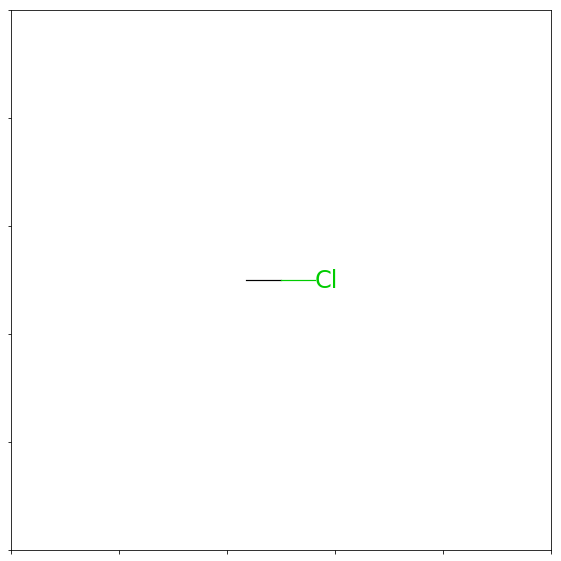

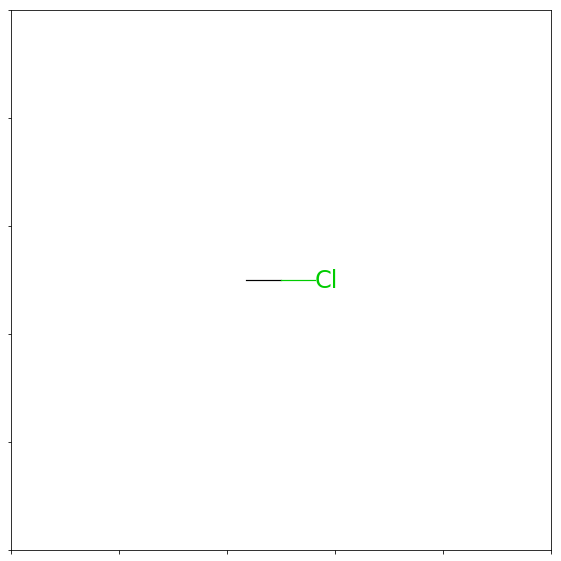

In [7]:
temp = Chem.MolFromSmiles('CCl')

# mol1 = Node('CC1=CC=CC=C1',0)
# mol2 = Node('c1ccccc1C',0)
# get_morgan_fingerprint(mol1,mol2,2)


# mol1 = Node('C=CCCCCC',0)
# mol2 = Node('C=CCCCC',0)
# get_morgan_fingerprint(mol1,mol2,2)
Draw.MolToMPL(temp)

# A* search reverse direction

In [15]:
class Node:
    def __init__(self, mol_string, step, parent = None, template = None):
        
        self.mol = Chem.MolFromSmiles(mol_string)
        self.parent = parent
        self.mol_string = mol_string
        self.step = step
        self.template = template
        self.g = 0
        self.h = 0
        self.f = 0
        
def get_current_mol(mol_list, visited):
    
    mols_left = set(mol_list) - visited
    if len(mols_left) > 0:
        mols_left = list(mols_left)
        if len(mols_left) == 1:
            return mols_left[0]
        else:
            min_f, current_mol = 100, mols_left[0]
            for mol in mols_left:
                if mol.f < min_f:
                    min_f = mol.f
                    current_mol = mol
        return current_mol
    else:
        return None
    
def get_heuristic(currmol, starting_node):
    
    fp_mol = Chem.RDKFingerprint(currmol.mol)
    fp_starting_node = Chem.RDKFingerprint(starting_node.mol)
    return 1 - DataStructs.FingerprintSimilarity(fp_mol,fp_starting_node)

def get_morgan_fingerprint(currmol, starting_node, radius):
    
    fp_mol = AllChem.GetMorganFingerprint(currmol.mol,radius)
    fp_starting_node = AllChem.GetMorganFingerprint(starting_node.mol,radius)
    return 1 - DataStructs.DiceSimilarity(fp_mol,fp_starting_node)

def get_prod_path(prod):
    
    immediate_parent = prod.parent
    ans = [prod.mol_string, immediate_parent.mol_string]
    ans_templates = [prod.template, immediate_parent.template]
    while True:
        parent = immediate_parent.parent
        if parent is None:
            break
        ans.append(parent.mol_string)
        ans_templates.append(parent.template)
        immediate_parent = parent
    ans = ans[::-1]
    ans_templates = ans_templates[::-1]
    ans = ' -> '.join(ans)
    return ans, ans_templates[1:]

def run_all_templates(starting_node, steps, backward_g, req_prod, sorted_smarts, morgan_fp = True, verbose = True):
    
    current_step,step_wise_mp,step_wise_products,step_wise_reac_prod, step_wise_template_numbers = 0,[],[],[],[]
    
    # A* search variables
    starting_node.g, starting_node.h, starting_node.f, starting_node.parent = 0,0,0,None
    new_mols, new_mols_string,visited_mols, visited_mol_string = [starting_node],set(),set(),set()
    new_mols_string.add(starting_node.mol_string)
    
    while current_step < steps and len(new_mols) > 0:
        
        local_mp,local_products,local_reac_prod, local_template_numbers = [],[],{},[]
        
        # Get current node
        curr_mol = get_current_mol(new_mols, visited_mols)
        if curr_mol is None:
            break
        print('\n')
        print("Node expanded: ",curr_mol.mol_string)
        
        mp, unique_products, unique_products_templates = {}, set(), []

        for i,smarts_dict in enumerate(sorted_smarts):
            
            reaction_smarts = smarts_dict['reaction_smarts']
            # Reversing smart template
            reaction_smarts_synth = '(' + reaction_smarts.split('>')[0] + ')>>(' + reaction_smarts.split('>')[2] + ')'
            # Applying reaction template
            rxn = AllChem.ReactionFromSmarts(reaction_smarts_synth)
            
            local_ans = set()
            try:
                outcomes = rxn.RunReactants([curr_mol.mol])
            except:
                continue

            for x in outcomes:
                try:
                    Chem.SanitizeMol(x[0])
                    if x[0] not in unique_products:
                        unique_products.add(Chem.MolToSmiles(x[0]))
                        unique_products_templates.append((Chem.MolToSmiles(x[0]), reaction_smarts_synth))
                        local_ans.add(Chem.MolToSmiles(x[0]))
                except:
                    continue
                
            if len(local_ans) > 0:
                mp[(reaction_smarts_synth,i)] = list(local_ans)
                local_template_numbers.append(i)
        
        # Keeping track of stuff like templates, all products etc
        local_mp.append(mp)
        local_products.extend([item for sublist in list(mp.values()) for item in sublist])
        local_reac_prod[curr_mol.mol_string] = [item for sublist in list(mp.values()) for item in sublist]
            
        local_template_numbers = sorted(local_template_numbers)
            
        step_wise_mp.append(local_mp)
        step_wise_products.append(local_products)
        step_wise_reac_prod.append(local_reac_prod)
        step_wise_template_numbers.append(local_template_numbers)
        
        # A* stuff
        for mol_str in unique_products_templates:
            if mol_str[0] not in visited_mol_string and mol_str[0] not in new_mols_string:
                temp = Node(mol_str[0], curr_mol.step + 1, parent = curr_mol, template = mol_str[1])
#                 temp.g = curr_mol.g + backward_g
                temp.g = get_morgan_fingerprint(temp,starting_node,2)
                if morgan_fp == True:
                    temp.h = get_morgan_fingerprint(temp,req_prod,2)
#                 temp.h = get_heuristic(temp, req_prod)
                temp.f = temp.g + temp.h
                new_mols.append(temp)
                new_mols_string.add(mol_str[0])
                if get_heuristic(temp,req_prod) == 0:
#                 if mol_str[0] == req_prod.mol_string:
                    path_to_prod, path_templates = get_prod_path(temp)
                    print('\n')
                    print("Found the product !!")
                    print("Path to product: ")
                    print(path_to_prod)
                    print('\n')
                    print("Templates used in path: ")
                    print(path_templates)
                    return step_wise_mp, step_wise_products, step_wise_reac_prod, step_wise_template_numbers
        visited_mols.add(curr_mol)
        visited_mol_string.add(curr_mol.mol_string)
        new_mols.remove(curr_mol)
        
        current_step = max(current_step, curr_mol.step)
        
        print("Step: ", current_step)        
#         print("Products: ", local_products)
#         print('\n')
        if verbose:
            print('\n')
            print("Number of unique products: ",len(list(set(local_products))))
            print('\n')
            print("Reactant - Product mapping: ")
            print(json.dumps(local_reac_prod, indent=4, sort_keys=True))
            print('\n')
#         print("Reaction Template numbers used: ", local_template_numbers)
#         print('\n' * 3)
        print('\n')
        print("New molecules to be explored: ")
        print('\n')
        for mol in new_mols:
            print(mol.mol_string, " ",mol.g, " ", mol.h," ", mol.f)
#         mols = list(set(local_products))
        
    return step_wise_mp, step_wise_products, step_wise_reac_prod, step_wise_template_numbers

reactant = 'CC1=CC=CC=C1'
product = "C1=CC=CC=C1"
starting_node = Node(reactant,0)
final_node = Node(product,0)
mp,products,reac_prod,template_numbers = run_all_templates(starting_node ,5, 0.25, final_node,sorted_smarts[:1700], morgan_fp = True, verbose = False)
# print(mp)
# print(template_numbers)
# print("Final step-wise dictionary: ", mp)
# print('\n' * 3)
# print("Final step-wise products: ", products)
# print('\n' * 3)
# print("Final reac-prod dictionary: ", json.dumps(reac_prod, indent=4, sort_keys=True))
# print('\n' * 3)
# print("Numbers of all templates used: ", template_numbers)



Node expanded:  CC1=CC=CC=C1
Step:  0


New molecules to be explored: 


Cc1ccccc1C   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(C)c1   0.38095238095238093   0.75   1.130952380952381
Cc1ccc(C)cc1   0.47619047619047616   0.8   1.276190476190476
Cc1ccccc1Cl   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(Cl)c1   0.4285714285714286   0.75   1.1785714285714286
Cc1ccc(Cl)cc1   0.47619047619047616   0.8   1.276190476190476
Cc1ccccc1Br   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(Br)c1   0.4285714285714286   0.75   1.1785714285714286
Cc1ccc(Br)cc1   0.47619047619047616   0.8   1.276190476190476
CCc1ccccc1   0.3023255813953488   0.5609756097560976   0.8633011911514464
Cc1ccccc1N   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(N)c1   0.4285714285714286   0.75   1.1785714285714286
Cc1ccc(N)cc1   0.47619047619047616   0.8   1.276190476190476
O=C(O)c1ccccc1   0.37777777777777777   0.5813953488372092   0.959173126614987
Cc1ccccc1O   0.38095238095238093   

Step:  2


New molecules to be explored: 


Cc1ccccc1C   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(C)c1   0.38095238095238093   0.75   1.130952380952381
Cc1ccc(C)cc1   0.47619047619047616   0.8   1.276190476190476
Cc1ccccc1Cl   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(Cl)c1   0.4285714285714286   0.75   1.1785714285714286
Cc1ccc(Cl)cc1   0.47619047619047616   0.8   1.276190476190476
Cc1ccccc1Br   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(Br)c1   0.4285714285714286   0.75   1.1785714285714286
Cc1ccc(Br)cc1   0.47619047619047616   0.8   1.276190476190476
CCc1ccccc1   0.3023255813953488   0.5609756097560976   0.8633011911514464
Cc1ccccc1N   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(N)c1   0.4285714285714286   0.75   1.1785714285714286
Cc1ccc(N)cc1   0.47619047619047616   0.8   1.276190476190476
O=C(O)c1ccccc1   0.37777777777777777   0.5813953488372092   0.959173126614987
Cc1ccccc1O   0.38095238095238093   0.7   1.0809523809523809
Cc1ccc

Step:  2


New molecules to be explored: 


Cc1ccccc1C   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(C)c1   0.38095238095238093   0.75   1.130952380952381
Cc1ccc(C)cc1   0.47619047619047616   0.8   1.276190476190476
Cc1ccccc1Cl   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(Cl)c1   0.4285714285714286   0.75   1.1785714285714286
Cc1ccc(Cl)cc1   0.47619047619047616   0.8   1.276190476190476
Cc1ccccc1Br   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(Br)c1   0.4285714285714286   0.75   1.1785714285714286
Cc1ccc(Br)cc1   0.47619047619047616   0.8   1.276190476190476
CCc1ccccc1   0.3023255813953488   0.5609756097560976   0.8633011911514464
Cc1ccccc1N   0.38095238095238093   0.7   1.0809523809523809
Cc1cccc(N)c1   0.4285714285714286   0.75   1.1785714285714286
Cc1ccc(N)cc1   0.47619047619047616   0.8   1.276190476190476
O=C(O)c1ccccc1   0.37777777777777777   0.5813953488372092   0.959173126614987
Cc1ccccc1O   0.38095238095238093   0.7   1.0809523809523809
Cc1ccc